# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model



In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [4]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [5]:
project_name='02-insurance-linear-regression-asgn' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [6]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [7]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [8]:
your_name = "sharanu" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [9]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [10]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
1178,23,female,36.2596,0,no,northeast,2812.504669
1295,20,male,22.8800,1,no,southwest,1905.836600
205,28,female,30.0352,1,no,northeast,4207.603144
1067,39,male,44.3612,0,no,northeast,5584.691047
523,38,female,39.2392,0,no,southeast,5235.688199


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [11]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [12]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [13]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [14]:
categorical_cols = ["sex","smoker","region"]
categorical_cols

['sex', 'smoker', 'region']

**Q: What are the column titles of output/target variable(s)?**

In [15]:
output_cols = ["charges"]

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [16]:
#Maximum value in the charges column
dataframe["charges"].max()

61857.3151697

In [17]:
#Minimum value in the charges column
dataframe["charges"].min()

1088.217683

In [18]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 1178 to 604
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   region    1271 non-null   object 
 6   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 79.4+ KB


In [19]:
dataframe.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We can see the Data what we have is not having any null values.

# Lets Explore the Data

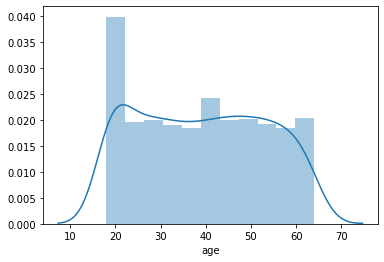

In [20]:
sns.distplot(dataframe["age"])

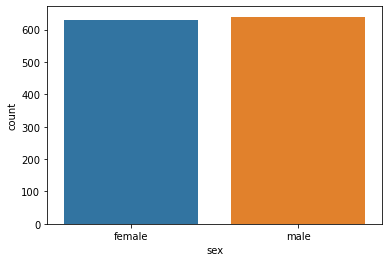

In [21]:
sns.countplot(dataframe["sex"])

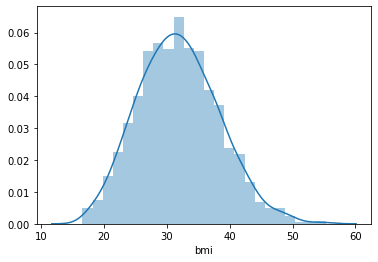

In [22]:
sns.distplot(dataframe["bmi"])

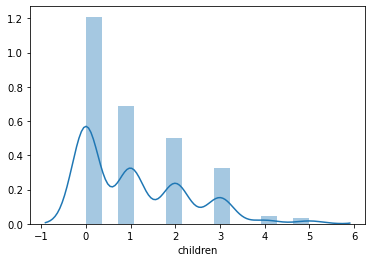

In [23]:
sns.distplot(dataframe["children"])

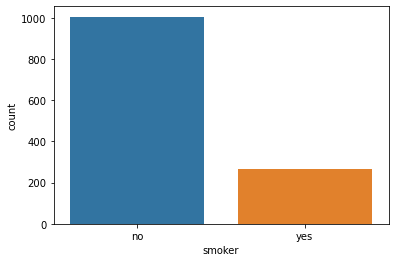

In [24]:
sns.countplot(dataframe["smoker"])

We can see that the count of smokers is lower than non smokers


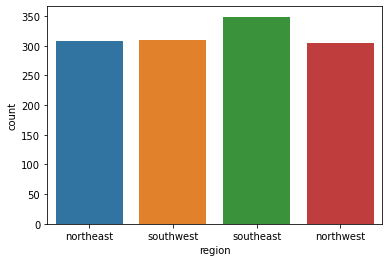

In [25]:
sns.countplot(dataframe["region"])

In [26]:
data=dataframe.copy()
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

In [27]:
data.corr()['charges'].sort_values()


region     -0.008947
sex         0.057305
children    0.071496
bmi         0.200544
age         0.291725
smoker      0.793688
charges     1.000000
Name: charges, dtype: float64

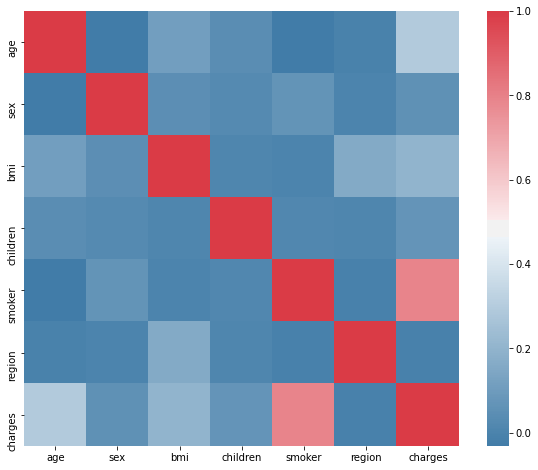

In [28]:
import numpy as np
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

A strong correlation is observed only with the fact of smoking the patient, We investigate smoking in more detail.

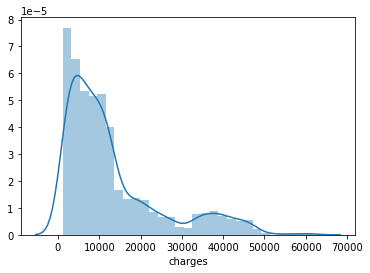

In [29]:
sns.distplot(data["charges"])

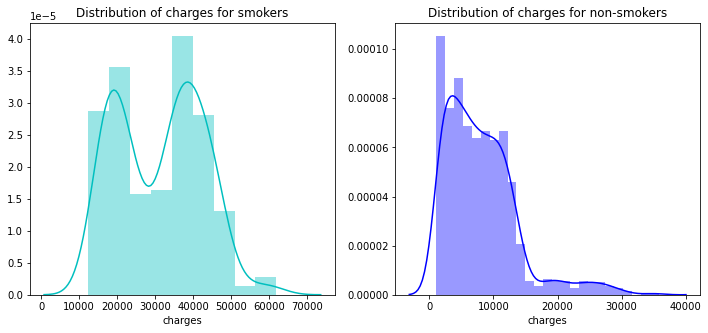

In [30]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')
plt.show()

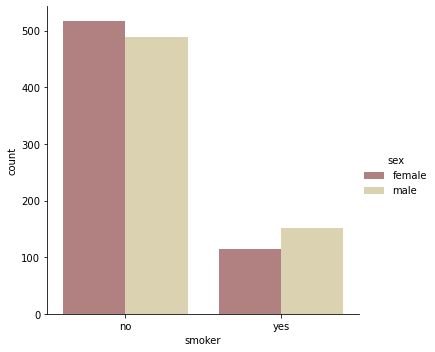

In [31]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=dataframe)

Thus non-smoking people and the truth more. Also we can notice that more male smokers than women smokers. It can be assumed that the total cost of treatment in men will be more than in women, given the impact of smoking. Maybe we'll check it out later. And some more useful visualizations

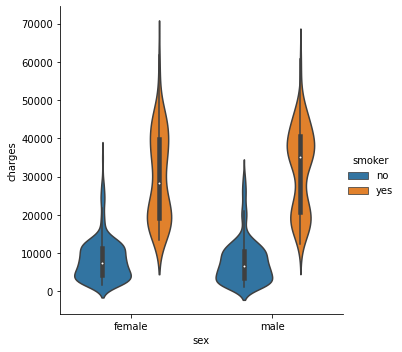

In [32]:
sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=dataframe)

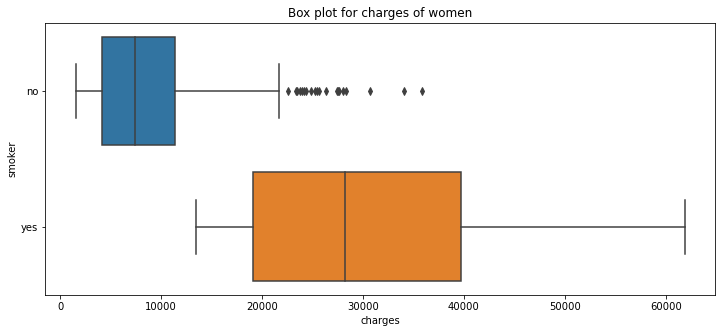

In [33]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  dataframe[(dataframe.sex == "female")] , orient="h")

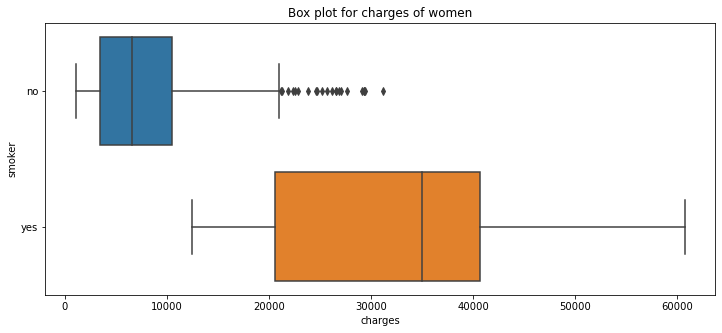

In [34]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  dataframe[(dataframe.sex == "male")] , orient="h")

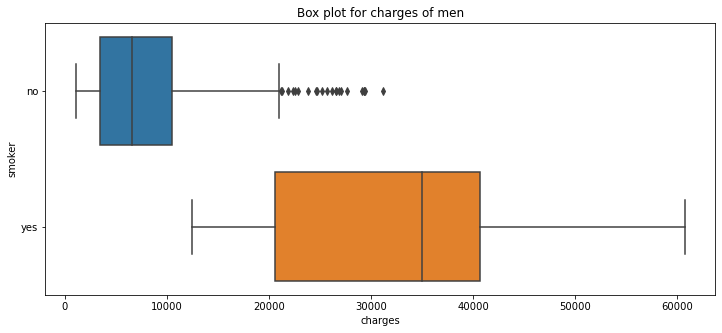

In [35]:
plt.figure(figsize=(12,5))
plt.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data =  dataframe[(dataframe.sex == "male")] , orient="h")

In [38]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sharanuullegaddi/02-insurance-linear-regression-asgn


<IPython.core.display.Javascript object>

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [39]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [40]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[23.    ,  0.    , 36.2596,  0.    ,  0.    ,  0.    ],
        [20.    ,  1.    , 22.88  ,  1.    ,  0.    ,  3.    ],
        [28.    ,  0.    , 30.0352,  1.    ,  0.    ,  0.    ],
        ...,
        [53.    ,  0.    , 27.768 ,  2.    ,  0.    ,  3.    ],
        [26.    ,  1.    , 28.1424,  0.    ,  1.    ,  2.    ],
        [19.    ,  0.    , 29.4424,  0.    ,  1.    ,  1.    ]]),
 array([[ 2812.5046695],
        [ 1905.8366   ],
        [ 4207.603144 ],
        ...,
        [10816.2566   ],
        [16532.041158 ],
        [16944.914383 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [41]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [42]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [43]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [44]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [45]:
batch_size = 128

In [46]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [47]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[59.0000,  0.0000, 33.3840,  3.0000,  0.0000,  3.0000],
        [54.0000,  0.0000, 32.4896,  0.0000,  0.0000,  2.0000],
        [32.0000,  0.0000, 45.9888,  0.0000,  0.0000,  2.0000],
        [23.0000,  1.0000, 38.5840,  3.0000,  0.0000,  3.0000],
        [35.0000,  1.0000, 38.1368,  1.0000,  1.0000,  0.0000],
        [56.0000,  0.0000, 37.2320,  1.0000,  0.0000,  3.0000],
        [37.0000,  1.0000, 30.8256,  0.0000,  0.0000,  1.0000],
        [19.0000,  0.0000, 25.4904,  1.0000,  0.0000,  1.0000],
        [61.0000,  1.0000, 45.1360,  0.0000,  0.0000,  3.0000],
        [47.0000,  0.0000, 27.6640,  2.0000,  0.0000,  0.0000],
        [34.0000,  0.0000, 30.4304,  3.0000,  0.0000,  2.0000],
        [32.0000,  0.0000, 18.4756,  2.0000,  1.0000,  1.0000],
        [54.0000,  0.0000, 49.3064,  0.0000,  1.0000,  2.0000],
        [52.0000,  0.0000, 19.0684,  0.0000,  0.0000,  1.0000],
        [21.0000,  0.0000, 22.7656,  2.0000,  0.0000,  2.0000],
        [41.0000,  1.0000, 24.89

Let's save our work by committing to Jovian.

In [48]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sharanuullegaddi/02-insurance-linear-regression-asgn


<IPython.core.display.Javascript object>

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [49]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size,output_size


(6, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [50]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)   # (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                         
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [51]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [52]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0849,  0.3647,  0.0022,  0.2833,  0.3948, -0.1938]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0279], requires_grad=True)]

One final commit before we train the model.

In [53]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sharanuullegaddi/02-insurance-linear-regression-asgn


<IPython.core.display.Javascript object>

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [54]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [55]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 12771.412109375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [56]:
epochs = 100
lr = 1e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6466.4092
Epoch [40], val_loss: 6314.1187
Epoch [60], val_loss: 6234.0430
Epoch [80], val_loss: 6230.5845
Epoch [100], val_loss: 6231.3350


In [57]:
epochs = 300
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6232.5176
Epoch [40], val_loss: 6232.5498
Epoch [60], val_loss: 6232.5068
Epoch [80], val_loss: 6233.4092
Epoch [100], val_loss: 6233.2705
Epoch [120], val_loss: 6233.2109
Epoch [140], val_loss: 6233.3662
Epoch [160], val_loss: 6232.9189
Epoch [180], val_loss: 6233.5142
Epoch [200], val_loss: 6233.3672
Epoch [220], val_loss: 6233.0820
Epoch [240], val_loss: 6232.7324
Epoch [260], val_loss: 6232.6123
Epoch [280], val_loss: 6232.6279
Epoch [300], val_loss: 6231.8369


In [58]:
epochs = 500
lr = 1e-3
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6232.0654
Epoch [40], val_loss: 6232.0864
Epoch [60], val_loss: 6232.0625
Epoch [80], val_loss: 6232.0732
Epoch [100], val_loss: 6232.0273
Epoch [120], val_loss: 6232.0361
Epoch [140], val_loss: 6232.0273
Epoch [160], val_loss: 6231.9834
Epoch [180], val_loss: 6231.9678
Epoch [200], val_loss: 6231.9497
Epoch [220], val_loss: 6231.9102
Epoch [240], val_loss: 6231.8828
Epoch [260], val_loss: 6231.8833
Epoch [280], val_loss: 6231.9072
Epoch [300], val_loss: 6231.8135
Epoch [320], val_loss: 6231.8086
Epoch [340], val_loss: 6231.8042
Epoch [360], val_loss: 6231.7471
Epoch [380], val_loss: 6231.6953
Epoch [400], val_loss: 6231.6606
Epoch [420], val_loss: 6231.6973
Epoch [440], val_loss: 6231.7148
Epoch [460], val_loss: 6231.6411
Epoch [480], val_loss: 6231.5938
Epoch [500], val_loss: 6231.5068


In [59]:
epochs = 600
lr = 1e-4
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6231.5117
Epoch [40], val_loss: 6231.5312
Epoch [60], val_loss: 6231.5347
Epoch [80], val_loss: 6231.5322
Epoch [100], val_loss: 6231.5239
Epoch [120], val_loss: 6231.5254
Epoch [140], val_loss: 6231.5312
Epoch [160], val_loss: 6231.5244
Epoch [180], val_loss: 6231.5098
Epoch [200], val_loss: 6231.5049
Epoch [220], val_loss: 6231.5107
Epoch [240], val_loss: 6231.5122
Epoch [260], val_loss: 6231.5112
Epoch [280], val_loss: 6231.5146
Epoch [300], val_loss: 6231.5103
Epoch [320], val_loss: 6231.5078
Epoch [340], val_loss: 6231.5137
Epoch [360], val_loss: 6231.5229
Epoch [380], val_loss: 6231.5142
Epoch [400], val_loss: 6231.5034
Epoch [420], val_loss: 6231.4844
Epoch [440], val_loss: 6231.4775
Epoch [460], val_loss: 6231.4805
Epoch [480], val_loss: 6231.4897
Epoch [500], val_loss: 6231.4814
Epoch [520], val_loss: 6231.4849
Epoch [540], val_loss: 6231.4800
Epoch [560], val_loss: 6231.4756
Epoch [580], val_loss: 6231.4717
Epoch [600], val_loss: 6231.4717


In [60]:
epochs = 500
lr = 1e-5
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6231.4727
Epoch [40], val_loss: 6231.4731
Epoch [60], val_loss: 6231.4731
Epoch [80], val_loss: 6231.4722
Epoch [100], val_loss: 6231.4727
Epoch [120], val_loss: 6231.4727
Epoch [140], val_loss: 6231.4727
Epoch [160], val_loss: 6231.4717
Epoch [180], val_loss: 6231.4736
Epoch [200], val_loss: 6231.4707
Epoch [220], val_loss: 6231.4712
Epoch [240], val_loss: 6231.4707
Epoch [260], val_loss: 6231.4707
Epoch [280], val_loss: 6231.4707
Epoch [300], val_loss: 6231.4707
Epoch [320], val_loss: 6231.4697
Epoch [340], val_loss: 6231.4692
Epoch [360], val_loss: 6231.4688
Epoch [380], val_loss: 6231.4683
Epoch [400], val_loss: 6231.4683
Epoch [420], val_loss: 6231.4688
Epoch [440], val_loss: 6231.4678
Epoch [460], val_loss: 6231.4678
Epoch [480], val_loss: 6231.4673
Epoch [500], val_loss: 6231.4668


**Q: What is the final validation loss of your model?**

Text(0, 0.5, 'losses')

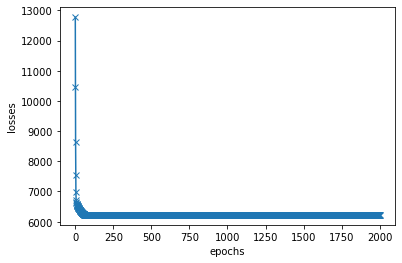

In [61]:
val_loss = [result] + history1 + history2 + history3 + history4 + history5

val_loss_list = [vl['val_loss'] for vl in val_loss]

plt.plot(val_loss_list, '-x')

plt.xlabel('epochs')
plt.ylabel('losses')

Let's log the final validation loss to Jovian and commit the notebook

In [62]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [63]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sharanuullegaddi/02-insurance-linear-regression-asgn


<IPython.core.display.Javascript object>

In [64]:
model = InsuranceModel()

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [65]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [66]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([36.0000,  1.0000, 35.8072,  0.0000,  1.0000,  2.0000])
Target: tensor([36610.2969])
Prediction: tensor([16.8455])


In [67]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([29.0000,  0.0000, 21.0444,  2.0000,  0.0000,  1.0000])
Target: tensor([4759.2173])
Prediction: tensor([12.7811])


In [68]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([60.0000,  1.0000, 26.7696,  0.0000,  0.0000,  2.0000])
Target: tensor([11778.3008])
Prediction: tensor([21.6072])


In [69]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sharanuullegaddi/02-insurance-linear-regression-asgn


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sharanuullegaddi/02-insurance-linear-regression-asgn


<IPython.core.display.Javascript object>